# Finding the number of cells in the microscope image and the attributes to be obtained from the cells


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import (erosion, dilation, opening, closing)
from skimage.morphology import disk
import cv2
from sklearn.cluster import KMeans

All libraries in need were imported The image is loaded and a sharpening filter
is applied. This filter emphasizes high-frequency components on an image and
makes it appear sharper. Filter is a Laplacian filter and generally used to
sharpen edges.


In [2]:
# Original image
img = cv2.imread('hucre.png', 0)

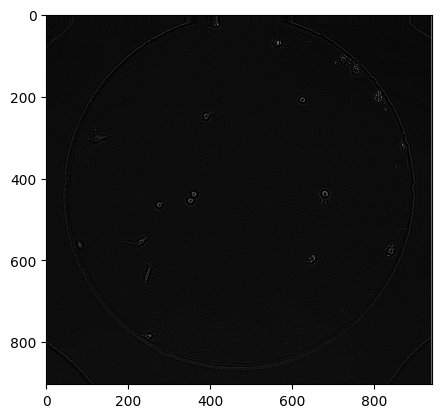

In [26]:
# Sharpening filter
kernel = np.array([[-1, -1, -1],
                   [-1, 8.103, -1],
                   [-1, -1, -1]])
img_shrp = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)

plt.imshow(img_shrp, cmap='gray')
plt.show()

Adaptive thresholding was applied to the image. Adaptive thresholding is a
technique that applies different threshold values to different regions of the
image.

The cv2.adaptiveThreshold function performs this operation. It takes the
sharpened image (img_shrp) as the first parameter. The second parameter (255)
specifies the maximum value after thresholding. The third parameter
(cv2.ADAPTIVE_THRESH_MEAN_C) specifies the adaptive thresholding method to be
used. In this case, the threshold value is set as the average of the neighboring
area. The fourth parameter (cv2.THRESH_BINARY) specifies the type of
thresholding. In this case, binary thresholding is used, i.e. pixels above the
threshold value are set to the maximum value (255), pixels below it are set
to 0. The fifth parameter (15) specifies the size of the neighboring area for
which the threshold value is calculated. The last parameter (19) specifies the
constant value subtracted from the threshold value.

There have been many experiments to determine the optimal values with the
sharpening filter, adaptive thresh mean with thresh binary being the most
suitable. Also experimented with adaptive gaussian, binary only, Otsu
thresholding and Local thresholding methods, but settled on this method as it
gave the best output for labeling.


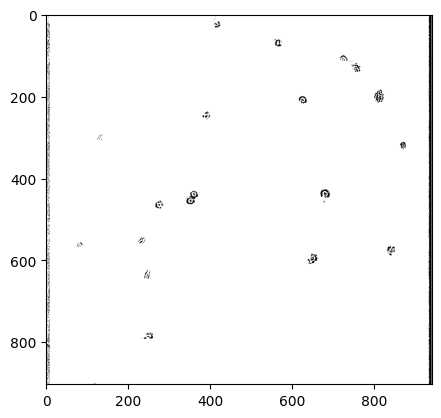

In [27]:
# adaptive thresholding with binary thresholding
img_adaptiveTh = cv2.adaptiveThreshold(
    img_shrp, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 19)

plt.imshow(img_adaptiveTh, cmap='gray')
plt.show()

Opening is used as a morphological transformation and the called method is
performed by first applying erosion and then dilation.


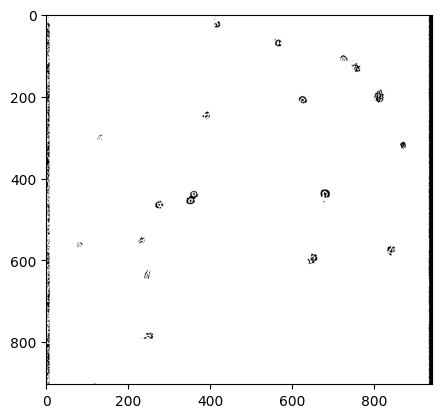

In [28]:
footprint = disk(1)

# best case provided with opening method
# closing and erosion provides cleaner and seperate cells but many cells might not be identified
'''img_eroded = erosion(img_adaptiveTh, footprint)
img_dilated = dilation(img_adaptiveTh, footprint)
img_closing = closing(img_adaptiveTh, footprint)'''
img_opening = opening(img_adaptiveTh, footprint)

plt.imshow(img_opening, cmap='gray')
plt.show()

Gaussian blur used for balancing the noise


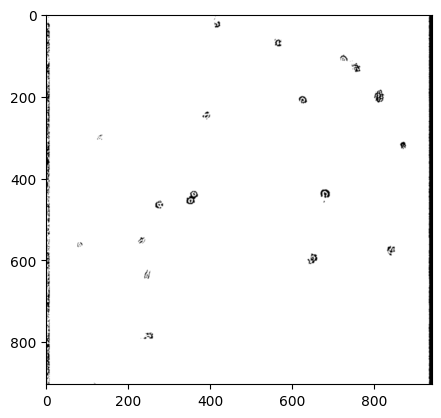

In [29]:
# Gaussian blur
img_blur = cv2.GaussianBlur(img_opening, (3, 3), 0)

plt.imshow(img_blur, cmap='gray')
plt.show()

Canny algorithm is used for edge detection


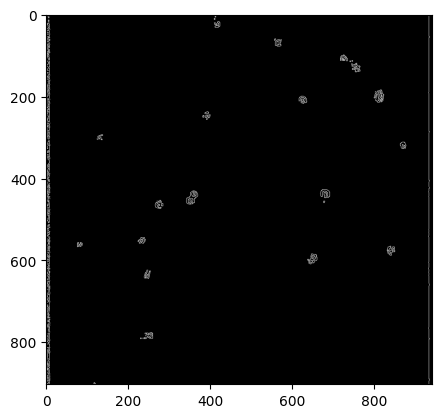

In [30]:
# canny edge detection
edges = cv2.Canny(img_blur, 100, 200)
plt.imshow(edges, cmap='gray')
plt.show()

Dilation is applied to the edge detected image using the cv2.dilate function.
While applying dilation, a morph ellipse with 2 by 2 and 7 repetitions was used,
different morph objects were tried and the best result was obtained with the
ellipse. All options 8 by 8, 7 by 7, 6 by 6, 5 by 5, 4 by 4, 3 by 3 were tried
up to 15 iterations. The best results (especially for labeling) were obtained in
2 by 2 in 7 iterations. Closing, erosion is not used because it makes the cells
in the image less distinct.


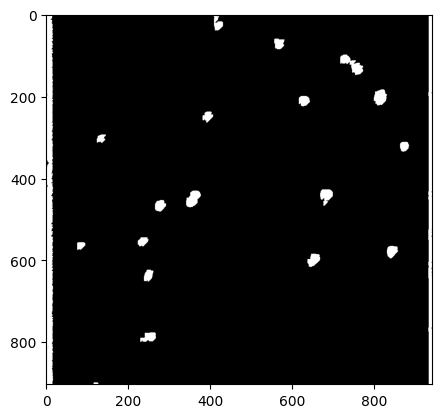

In [31]:
# dilation
kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
img_dilated = cv2.dilate(edges, kernel1, iterations=7)
plt.imshow(img_dilated, cmap='gray')
plt.show()

Connected components used for working on the edited image with the opencv's
connectedComponentsWithStats function


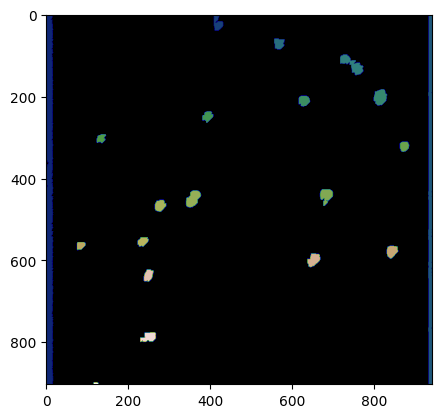

In [54]:
# Apply connected components with stats analysis
totalLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    img_dilated, connectivity=8, ltype=cv2.CV_32S)

# Replace the background label with -1
labels[labels == 0] = -1

# Remove the background centroid
centroids = centroids[1:]
sizes = stats[1:, -1]
totalLabels = totalLabels - 1

plt.imshow(labels, cmap='gist_earth')
plt.show()

KMeans clustering algorithm uses the fixed centers of the components and divides
them into a certain number of clusters for us. The number of clusters
(n_clusters) is kept the same as the total number of components (totalLabels).
This is experimented with 6 - 4 - 10 - 11 - 15 different clusters and all of
them give good results, but for better use, kept as label amount automatically
transferred as number of clusters, so I decided to keep the number of labels as
many as there are.


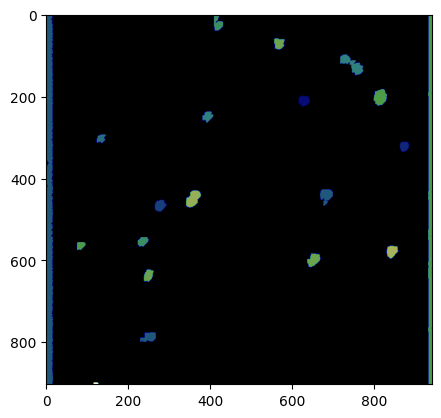

In [55]:
# Number of clusters
n_clusters = totalLabels

# Apply KMeans
kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(centroids)

# Assign each component to a cluster
labels_clustered = kmeans.labels_

# Replace the original labels with the clustered labels
for i in range(len(centroids)):
    labels[labels == i] = labels_clustered[i]

plt.imshow(labels, cmap='gist_earth')
plt.show()

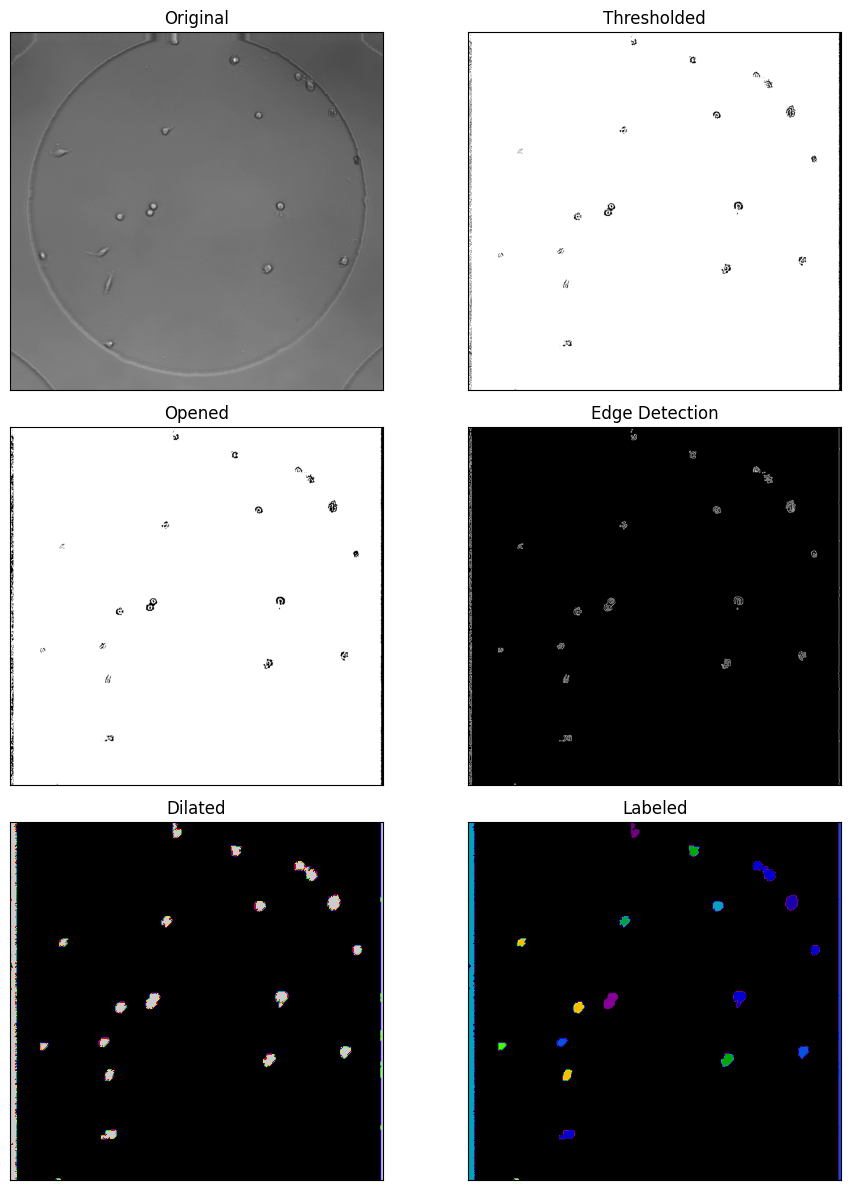

In [10]:
# Creating figure, img
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)
      ) = plt.subplots(3, 2, figsize=(10, 12))

# Display the original image
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title(f'Original', fontsize=12)
ax1.set_xticks([])
ax1.set_yticks([])

# Display the thresholded image
ax2.imshow(img_adaptiveTh, cmap=plt.cm.gray)
ax2.set_title(f'Thresholded', fontsize=12)
ax2.set_xticks([])
ax2.set_yticks([])

# Display the opened image
ax3.imshow(img_opening, cmap=plt.cm.gray)
ax3.set_title(f'Opened', fontsize=12)
ax3.set_xticks([])
ax3.set_yticks([])

# Display the inverted image
ax4.imshow(edges, cmap=plt.cm.gray)
ax4.set_title(f'Edge Detection', fontsize=12)
ax4.set_xticks([])
ax4.set_yticks([])


# Display the dilated image
ax5.imshow(img_dilated, cmap="nipy_spectral")
ax5.set_title(f'Dilated', fontsize=12)
ax5.set_xticks([])
ax5.set_yticks([])


# Display the labeled image
ax6.imshow(labels, cmap="nipy_spectral")
ax6.set_title(f'Labeled', fontsize=12)
ax6.set_xticks([])
ax6.set_yticks([])

# Empty subplot for layout purposes & show
plt.tight_layout()
plt.show()

In [11]:
cx = np.zeros(totalLabels)
cy = np.zeros(totalLabels)
area = np.zeros(totalLabels)
perimeter = np.zeros(totalLabels, dtype=int)
aspect_ratio = np.zeros(totalLabels)
equi_diameter = np.zeros(totalLabels)


# calculating area, orientation and circularity
properties = np.zeros((totalLabels, 3))  # 3 for area, orientation, circularity

for i in range(0, totalLabels):
    img2 = np.zeros((labels.shape), dtype=np.uint8)
    img2[labels == i] = 255
    # Find contours
    contours, _ = cv2.findContours(img2, 1, 2)

    if contours:
        cnt = contours[0]
        # Area
        area = cv2.contourArea(cnt)
        properties[i, 0] = area  # Store area

        # Orientation (angle between the x-axis and the major axis of the ellipse)
        if len(cnt) >= 5:  # Need at least 5 points to compute
            (x, y), (MA, ma), angle = cv2.fitEllipse(cnt)
            properties[i, 1] = angle

        # Circularity (ratio of the area of the contour and the square of the contour perimeter)
        perimeter = cv2.arcLength(cnt, True)
        if perimeter > 0:  # Avoid division by zero
            circularity = 4 * np.pi * area / (perimeter ** 2)
            properties[i, 2] = circularity

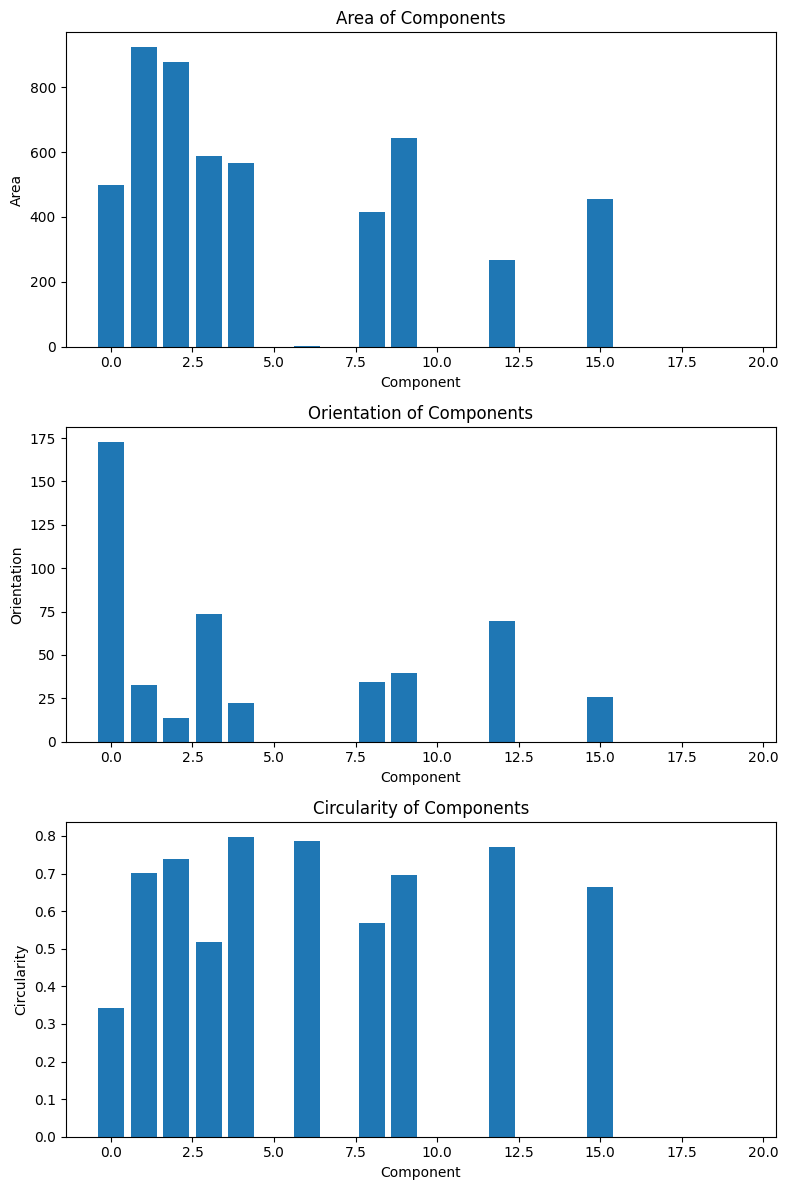

In [12]:
# Plotting properties for each component
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 12))

# Plot area
ax1.bar(range(totalLabels), properties[:, 0])
ax1.set_xlabel('Component')
ax1.set_ylabel('Area')
ax1.set_title('Area of Components')

# Plot orientation
ax2.bar(range(totalLabels), properties[:, 1])
ax2.set_xlabel('Component')
ax2.set_ylabel('Orientation')
ax2.set_title('Orientation of Components')

# Plot circularity
ax3.bar(range(totalLabels), properties[:, 2])
ax3.set_xlabel('Component')
ax3.set_ylabel('Circularity')
ax3.set_title('Circularity of Components')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [13]:
# calculating compactness and ratio of the area to the perimeter
labels = cv2.convertScaleAbs(labels)
edges_new = cv2.Canny(labels, 100, 200)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Lists to store data for visualization
ratios = []
compactness_values = []

for i, cnt in enumerate(contours):
    # Area
    area = cv2.contourArea(cnt)

    # Perimeter
    perimeter = cv2.arcLength(cnt, True)

    # Area to perimeter ratio and compactness
    if perimeter > 0 and area > 0:  # Avoid division by zero
        area_perimeter_ratio = area / perimeter
        compactness = (4 * np.pi * area) / \
            (perimeter ** 2)  # Compactness definition
    else:
        area_perimeter_ratio = 0
        compactness = 0

    # Append values to the lists
    ratios.append(area_perimeter_ratio)
    compactness_values.append(compactness)

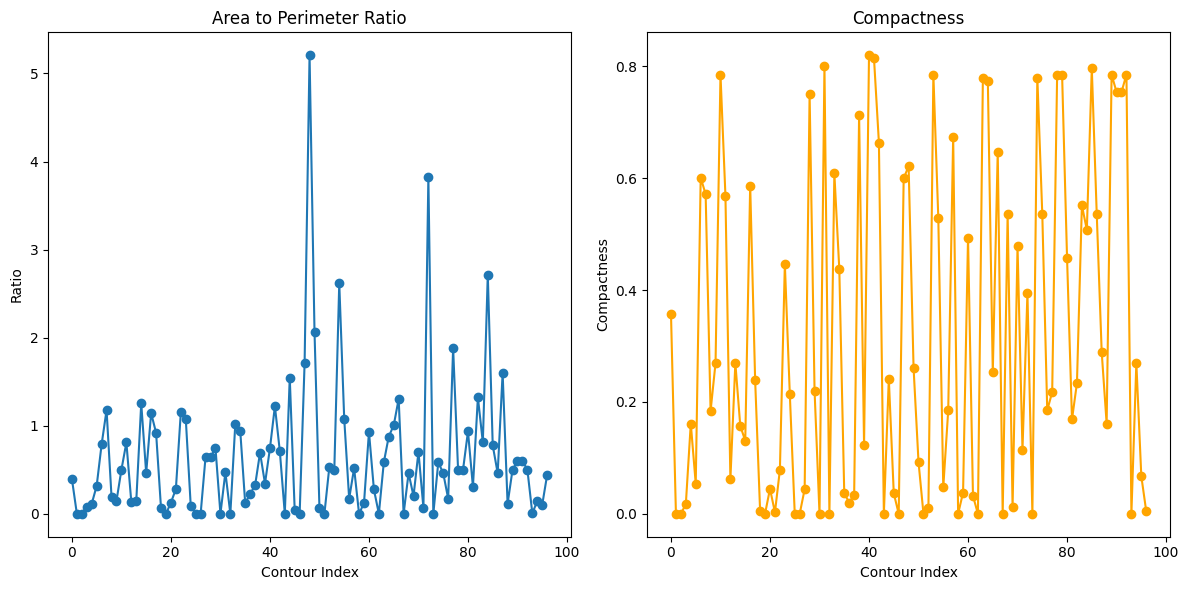

In [14]:
# Visualize the data
plt.figure(figsize=(12, 6))

# Plotting Area to Perimeter Ratio
plt.subplot(1, 2, 1)
plt.plot(ratios, marker='o')
plt.title('Area to Perimeter Ratio')
plt.xlabel('Contour Index')
plt.ylabel('Ratio')

# Plotting Compactness
plt.subplot(1, 2, 2)
plt.plot(compactness_values, marker='o', color='orange')
plt.title('Compactness')
plt.xlabel('Contour Index')
plt.ylabel('Compactness')

plt.tight_layout()
plt.show()